In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.cluster import KMeans # а также другие алгоритмы
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

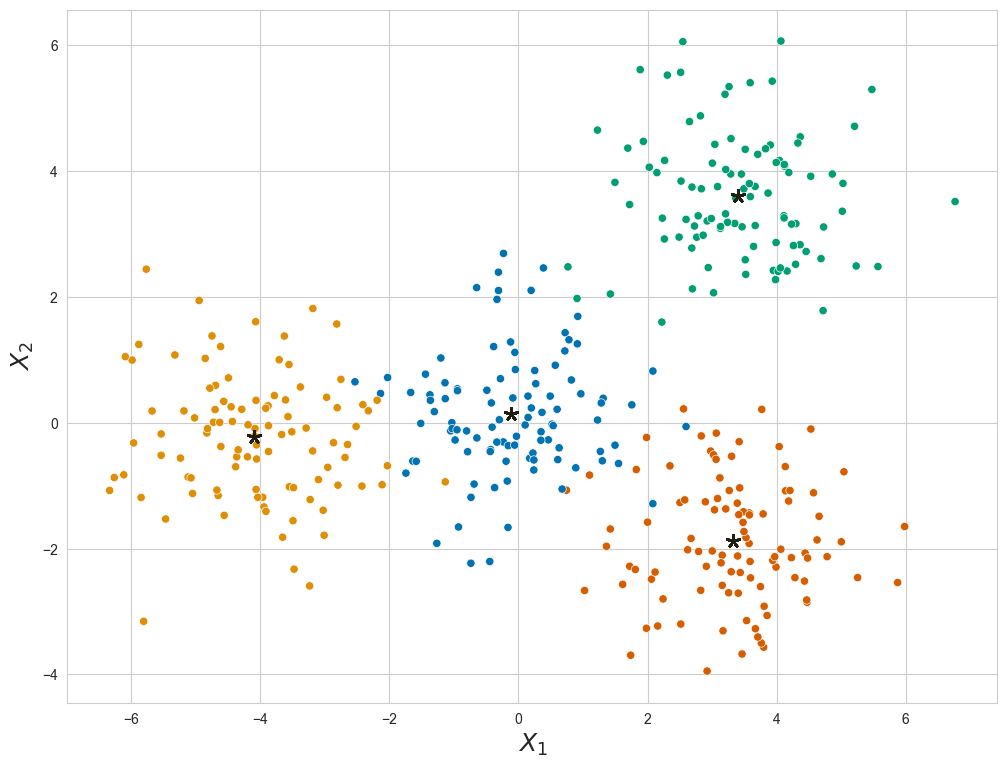

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dist = self._calculate_distance(X, centroid)
                dist = np.reshape(dist, (X.shape[0], 1))
                dists.append(dist)
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        
        dists = []
        for centroid in self.centroids:
            dist = self._calculate_distance(X, centroid)
            dist = np.reshape(dist, (X.shape[0], 1))
            dists.append(dist)
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = np.sqrt(np.sum((X - centroid) ** 2, axis=1))
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

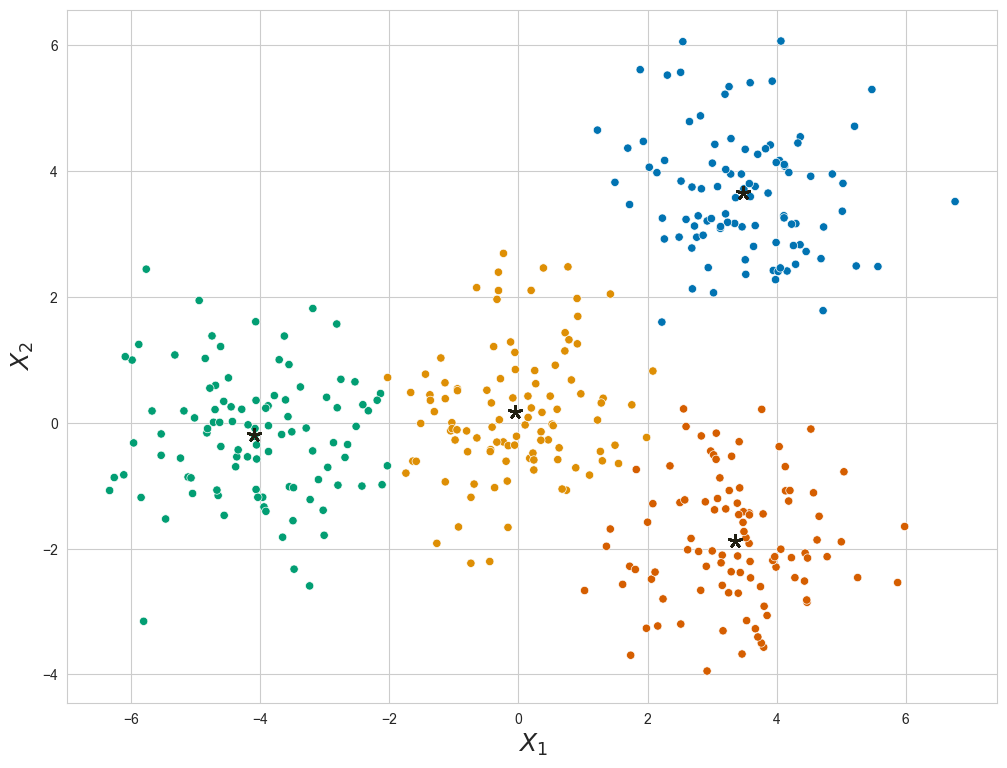

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
# Создаём модель и визуализируем
# В данном случае используем способ инициализации random

kmean_model = MyKMeans(n_clusters=4, max_iter=30, visualize=True)

# Обучаем 
kmean_model.fit(X)

In [8]:
# Пресказываем для каждой точки принадлежность к кластеру 
# Labels of clusters - 0, 1, 2, 3
predictions = kmean_model.predict(X)
predictions[:5]

array([0, 1, 3, 1, 1])

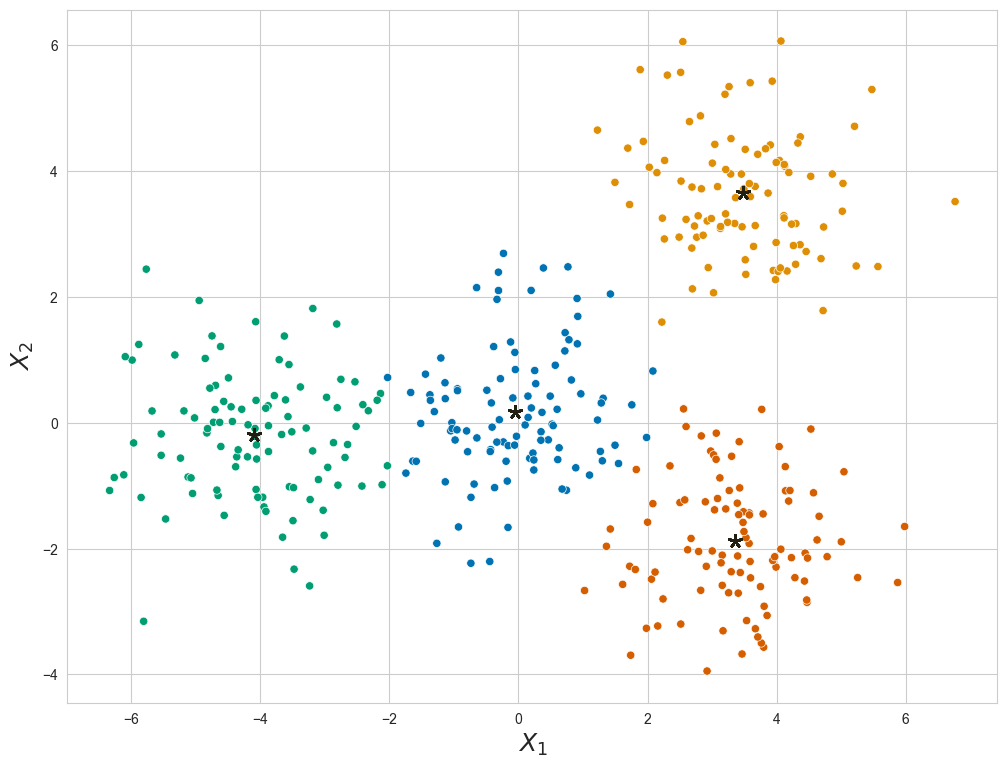

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [9]:
# В данном случае используем способ инициализации sample. Выбираем из объектов выборки 
kmean_model = MyKMeans(n_clusters=4, init="sample", max_iter=30, visualize=True)

# Обучаем 
kmean_model.fit(X)

**Вывод**
- Уже при выполнении 30 итераций все центроиды приближаются к своим оптимальным значениям
- Оба способа инициализации показали идентичные результаты уже с 5 итерации. Скорее всего это связано с тем, что мы используем достаточно "очевидную" выборку. Но, в целом, можно сказать, что оба способа инициализации равнозначны

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [10]:
data = load_digits()
X, y = data.data, data.target

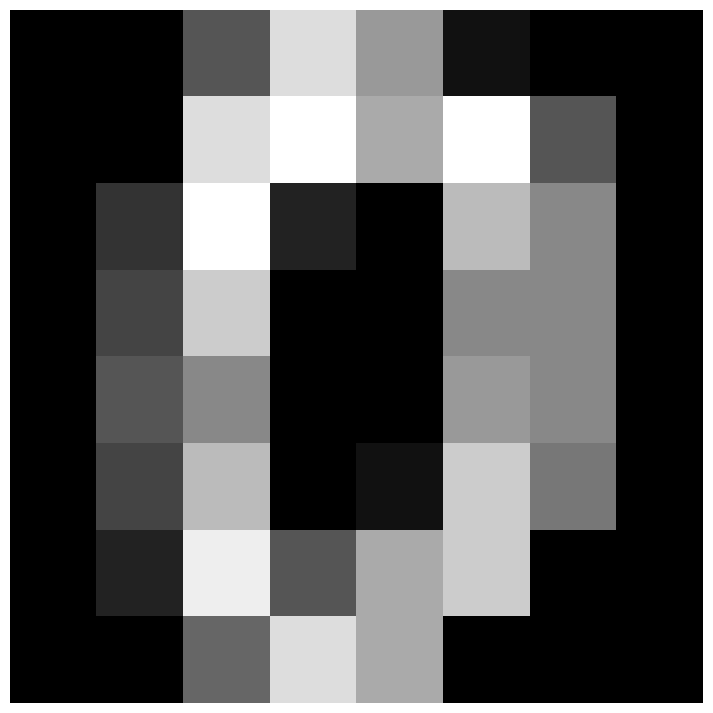

In [11]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

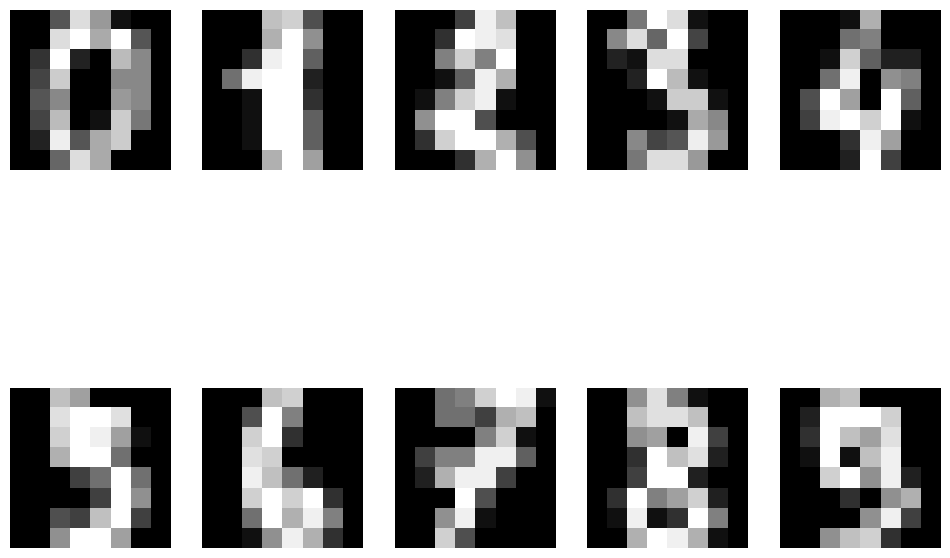

In [12]:
x = np.linspace(-10, 10, 20)

for number_class in range(10):
    plt.subplot(2, 5, number_class + 1)
    image = X[np.where(y == number_class)[0][0]].reshape(8, 8)
    plt.imshow(image, cmap="gray")
    plt.axis("off")   

The whole dataset contains 1797 images

Distribution of classes:


0    1    2    3    4    5    6    7    8    9
Count  178  182  177  183  181  182  181  179  174  180

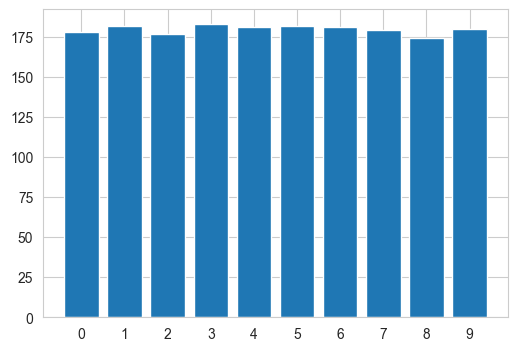

In [13]:
# Делаю небольшой EDA 
# Все представленные классы сбалансированы 

number_whole_data = X.shape[0]
print(f"The whole dataset contains {number_whole_data} images")
print('')
count_table = pd.DataFrame()

for number_class in range(10):
    count_image = len(np.where(y == number_class)[0])
    count_class = pd.DataFrame({str(number_class): [count_image]}, index=['Count'])
    count_table = pd.concat([count_table, count_class], axis=1)
    
print("Distribution of classes:")
display.display(count_table)

fig = plt.subplots(figsize=(6, 4))
labels, counts = np.unique(y, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()
None

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [14]:
def algorithm_selection(X, y, distances, algorithms, metrics, n_clusters):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
        :param n_clusters: количество наших кластеров
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """
    distances_list = []
    linkages_list = []
    homogenity_scores = []
    completeness_scores = []
    v_measure_scores = []
    silhouette_scores = []
    for algorithm in algorithms:
        for distance in distances:
            distances_list.append(distance)
            linkages_list.append(algorithm)
            agg_clust = AgglomerativeClustering(n_clusters=n_clusters, metric=distance, linkage=algorithm)
            predictions = agg_clust.fit_predict(X)
            if 'homogenity' in metrics:
                homogenity = homogeneity_score(y, predictions)
                homogenity_scores.append(homogenity)
            if 'completeness' in metrics:
                completeness = completeness_score(y, predictions)
                completeness_scores.append(completeness)
            if 'v_measure' in metrics:
                v_measure = v_measure_score(y, predictions)
                v_measure_scores.append(v_measure)
            if 'silhouette' in metrics:
                silhouette = silhouette_score(X, predictions, metric=distance)
                silhouette_scores.append(silhouette)
    distances_list = pd.DataFrame(distances_list, columns=['distance'])
    linkages_list = pd.DataFrame(linkages_list, columns=['linkage'])
    homogenity_scores = pd.DataFrame(homogenity_scores, columns=['homogenity'])
    completeness_scores = pd.DataFrame(completeness_scores, columns=['completeness'])
    v_measure_scores = pd.DataFrame(v_measure_scores, columns=['v_measure'])
    silhouette_scores = pd.DataFrame(silhouette_scores, columns=['silhouette'])
    compare_dataframe = pd.concat((distances_list, 
                                   linkages_list, 
                                   homogenity_scores, 
                                   completeness_scores, 
                                   v_measure_scores, 
                                   silhouette_scores), axis=1)
    
    return compare_dataframe

In [15]:
# Определяем интересующие значения 

distances = ['manhattan', 'euclidean', 'chebyshev', 'canberra', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = ['homogenity', 'completeness', 'v_measure', 'silhouette']
n_clusters = 10

In [16]:
# Получаем таблицу с результатами метрик 

comparison_table = algorithm_selection(X, y, distances, algorithms, metrics, n_clusters)
display.display(comparison_table)

distance   linkage  homogenity  completeness  v_measure  silhouette
0   manhattan   average    0.566751      0.778942   0.656117    0.105238
1   euclidean   average    0.655393      0.782342   0.713263    0.146625
2   chebyshev   average    0.769464      0.828645   0.797959    0.106666
3    canberra   average    0.573860      0.779789   0.661161    0.108401
4      cosine   average    0.648268      0.808762   0.719676    0.218229
5   manhattan    single    0.005102      0.276237   0.010019   -0.203816
6   euclidean    single    0.005056      0.273755   0.009929   -0.133621
7   chebyshev    single    0.006129      0.281430   0.011996   -0.026353
8    canberra    single    0.006144      0.280506   0.012025   -0.157872
9      cosine    single    0.005050      0.273389   0.009916   -0.281789
10  manhattan  complete    0.646372      0.686109   0.665648    0.160617
11  euclidean  complete    0.590549      0.637772   0.613253    0.119271
12  chebyshev  complete    0.067111      0.412582   0.115444   -0.079091
13   canberra  complete    0.528702      0.561588   0.544649    0.104411
14     cosine  complete    0.528727      0.577415   0.551999    0.144179

In [17]:
# Пронализируем показатель внутренней метрики silhouette
# Чем он больше, тем лучше 

comparison_table[comparison_table['silhouette'] == comparison_table.silhouette.max()]

distance  linkage  homogenity  completeness  v_measure  silhouette
4   cosine  average    0.648268      0.808762   0.719676    0.218229

In [18]:
# Проанализируем внешние метрики
# Гомогенность
comparison_table[comparison_table['homogenity'] == comparison_table.homogenity.max()]

distance  linkage  homogenity  completeness  v_measure  silhouette
2  chebyshev  average    0.769464      0.828645   0.797959    0.106666

In [19]:
# Проанализируем внешние метрики
# Полнота
comparison_table[comparison_table['completeness'] == comparison_table.completeness.max()]

distance  linkage  homogenity  completeness  v_measure  silhouette
2  chebyshev  average    0.769464      0.828645   0.797959    0.106666

In [20]:
# Проанализируем внешние метрики
# V-мера
comparison_table[comparison_table['v_measure'] == comparison_table.v_measure.max()]

distance  linkage  homogenity  completeness  v_measure  silhouette
2  chebyshev  average    0.769464      0.828645   0.797959    0.106666

**Вывод:**

- Для данного датасета наилучшие метрики при использовании иерархической кластеризации показывает Average method. Это и логично, так как он является сбалансированной версией между Complete и Single
- Исходя из внутренней метрики, то лучше всего для данного датасета использовать Cosine distance
- Исходя из внешних метрик, лучшие показатели достигаются при использовании Сhebyshev distance
- В целом у обоих этих подходов метрики, если не максимальные, то очень высокие. Поэтому, в данном случае использование обоих дистанций обосновано.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [21]:
DATA_PATH = '../data/raw_data/'
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [22]:
# Смотрим на данные
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [23]:
# В нашем датасете проанализировано 10000 клеток по 9 признакам
# Все перечисленные 9 признаков являются количественными
fc_data.shape  

(10000, 9)

In [24]:
# Данный датасет не содержит пропущенных значений
fc_data.isna().sum()

FSC-A     0
SSC-A     0
HLA-DR    0
CD3       0
CD45      0
CD14      0
CD56      0
CD19      0
CD11c     0
dtype: int64

In [25]:
# Предварительно смотрим на показатели каждого признака
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

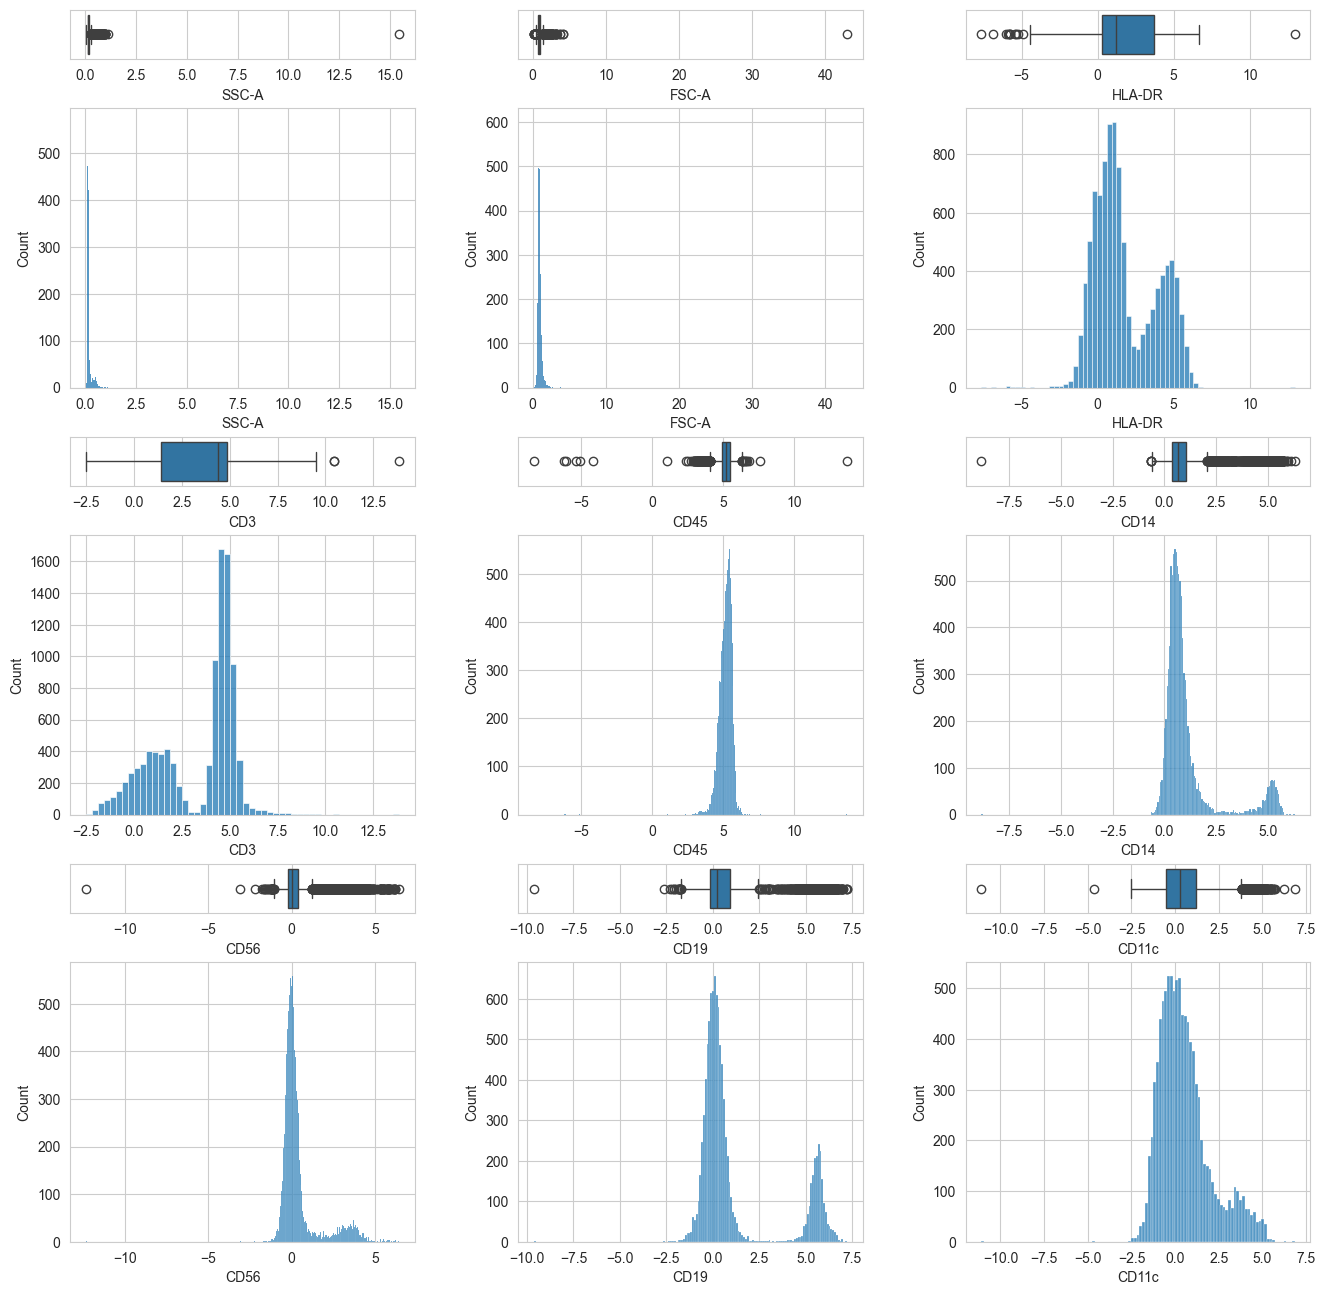

In [26]:
# Анализируем наличие выбросов

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 16), gridspec_kw={"height_ratios": (.15, .85, .15, .85,.15, .85)})
sns.boxplot(fc_data['SSC-A'], orient="h", ax=axes[0][0])
sns.histplot(fc_data['SSC-A'], ax=axes[1][0]).set(title='')

sns.boxplot(fc_data['FSC-A'], orient="h", ax=axes[0][1]) 
sns.histplot(fc_data['FSC-A'], ax=axes[1][1])

sns.boxplot(fc_data['HLA-DR'], orient="h", ax=axes[0][2]) 
sns.histplot(fc_data['HLA-DR'], ax=axes[1][2])

sns.boxplot(fc_data['CD3'], orient="h", ax=axes[2][0]) 
sns.histplot(fc_data['CD3'], ax=axes[3][0])

sns.boxplot(fc_data['CD45'], orient="h", ax=axes[2][1]) 
sns.histplot(fc_data['CD45'], ax=axes[3][1])

sns.boxplot(fc_data['CD14'], orient="h", ax=axes[2][2]) 
sns.histplot(fc_data['CD14'], ax=axes[3][2])

sns.boxplot(fc_data['CD56'], orient="h", ax=axes[4][0]) 
sns.histplot(fc_data['CD56'], ax=axes[5][0])

sns.boxplot(fc_data['CD19'], orient="h", ax=axes[4][1]) 
sns.histplot(fc_data['CD19'], ax=axes[5][1])

sns.boxplot(fc_data['CD11c'], orient="h", ax=axes[4][2]) 
sns.histplot(fc_data['CD11c'], ax=axes[5][2])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show();


**Предварительный анализ**
- Есть один явный выброс, не соотвествующий размерам клетки. Скорее всего это мусор - выбрасываем его.
- Исходя из анализа показателей сигналов флуоресценции, в них также существуют выбросы. Скорее всего популяции клеток должны формировать достаточно гомогенную выборку. Определяем границы распределений и выбрасываем наблюдения
- Некоторые сигналы имеют бимодальное рапределние. Не считаю это выбросами. Скорее всего, это разные популяции клеток.

In [27]:
# Определяем выбросы

outliers = fc_data[(fc_data['SSC-A'] > 10) | 
           (fc_data['HLA-DR'] > 10) | 
           (fc_data['HLA-DR'] < -5) | 
           (fc_data['CD3'] > 10) | 
           (fc_data['CD45'] < 0) | 
           (fc_data['CD45'] > 10) | 
           (fc_data['CD14'] < -7.5) | 
           (fc_data['CD56'] < -5) | 
           (fc_data['CD19'] < -7.5) | 
           (fc_data['CD11c'] < -3)]
print(f'Dataset has {outliers.shape[0]} outliers')

Dataset has 11 outliers


In [28]:
# Удаляем выбросы из датасета

fc_data = fc_data.drop(index=outliers.index)

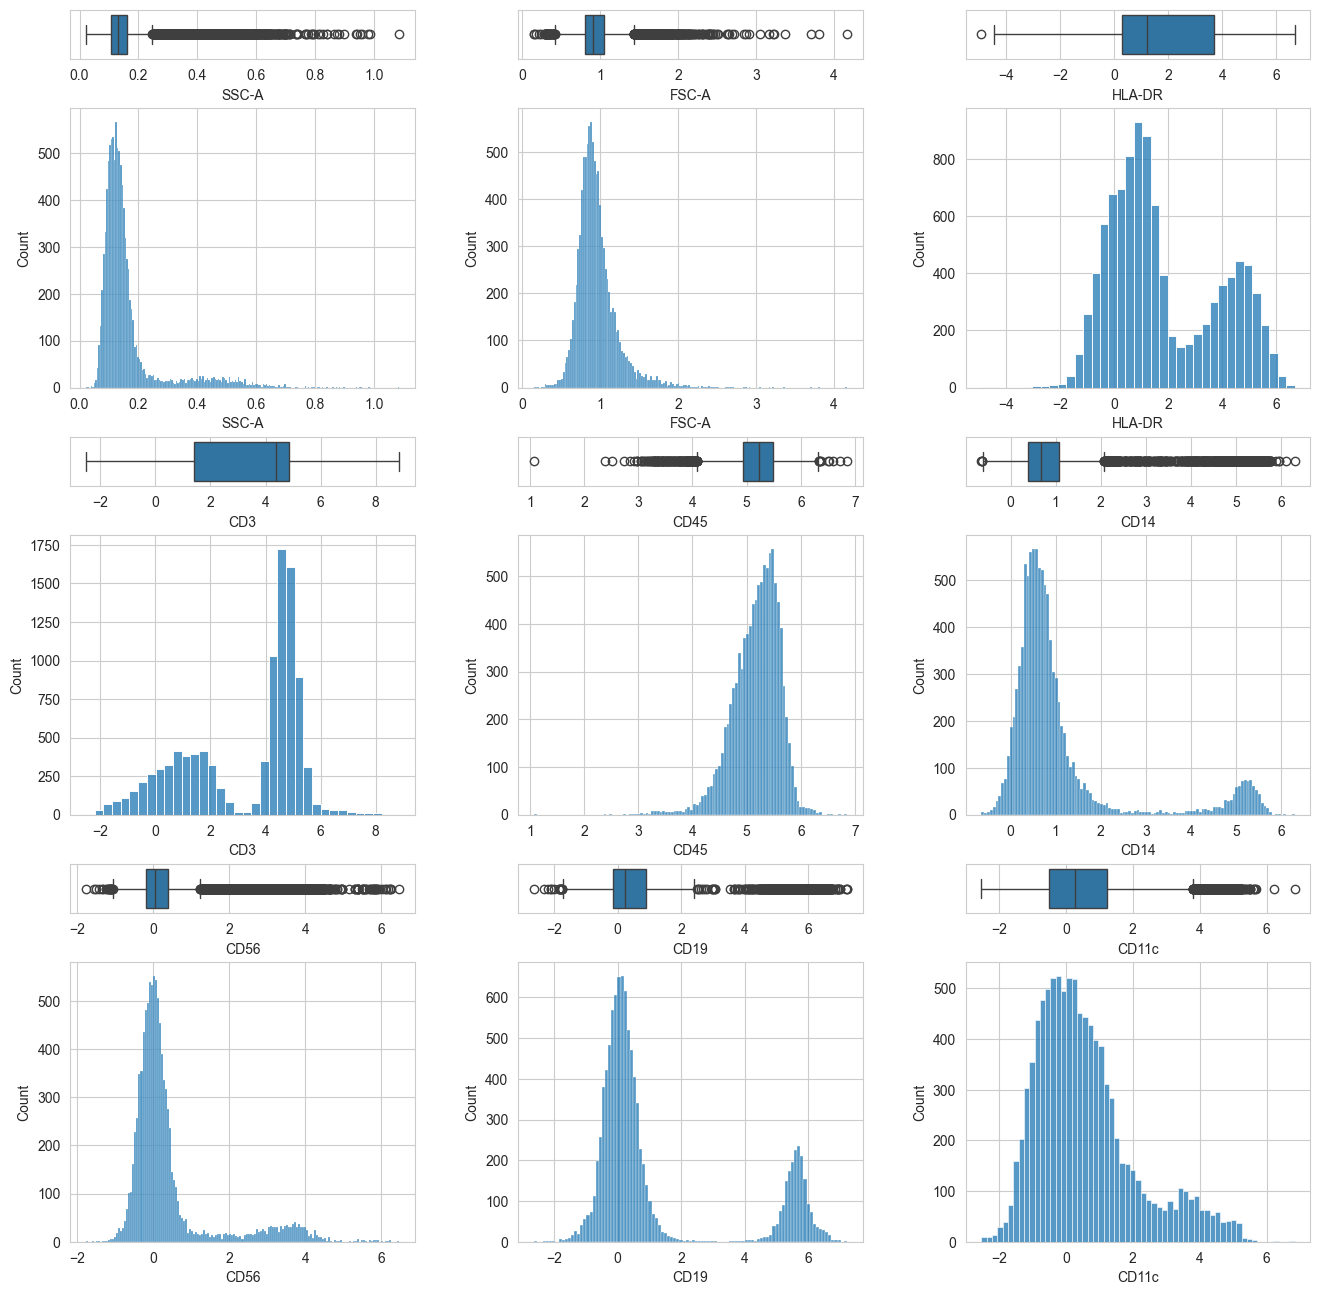

In [29]:
# Анализируем полученный датасет
# Графики стали получше

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 16), gridspec_kw={"height_ratios": (.15, .85, .15, .85,.15, .85)})
sns.boxplot(fc_data['SSC-A'], orient="h", ax=axes[0][0])
sns.histplot(fc_data['SSC-A'], ax=axes[1][0]).set(title='')

sns.boxplot(fc_data['FSC-A'], orient="h", ax=axes[0][1]) 
sns.histplot(fc_data['FSC-A'], ax=axes[1][1])

sns.boxplot(fc_data['HLA-DR'], orient="h", ax=axes[0][2]) 
sns.histplot(fc_data['HLA-DR'], ax=axes[1][2])

sns.boxplot(fc_data['CD3'], orient="h", ax=axes[2][0]) 
sns.histplot(fc_data['CD3'], ax=axes[3][0])

sns.boxplot(fc_data['CD45'], orient="h", ax=axes[2][1]) 
sns.histplot(fc_data['CD45'], ax=axes[3][1])

sns.boxplot(fc_data['CD14'], orient="h", ax=axes[2][2]) 
sns.histplot(fc_data['CD14'], ax=axes[3][2])

sns.boxplot(fc_data['CD56'], orient="h", ax=axes[4][0]) 
sns.histplot(fc_data['CD56'], ax=axes[5][0])

sns.boxplot(fc_data['CD19'], orient="h", ax=axes[4][1]) 
sns.histplot(fc_data['CD19'], ax=axes[5][1])

sns.boxplot(fc_data['CD11c'], orient="h", ax=axes[4][2]) 
sns.histplot(fc_data['CD11c'], ax=axes[5][2])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show();


В целом, все наши показатели находятся в одном диапазоне. Только показатели размеров немного отличаются. 

Изначально я решила стандартизовать наши данные, однако это привело к очень странным результатам. Все результаты сбились в одну кучу и предсказывались как один кластер. Поэтому далее провожу анализ без стандартизации.

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [30]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

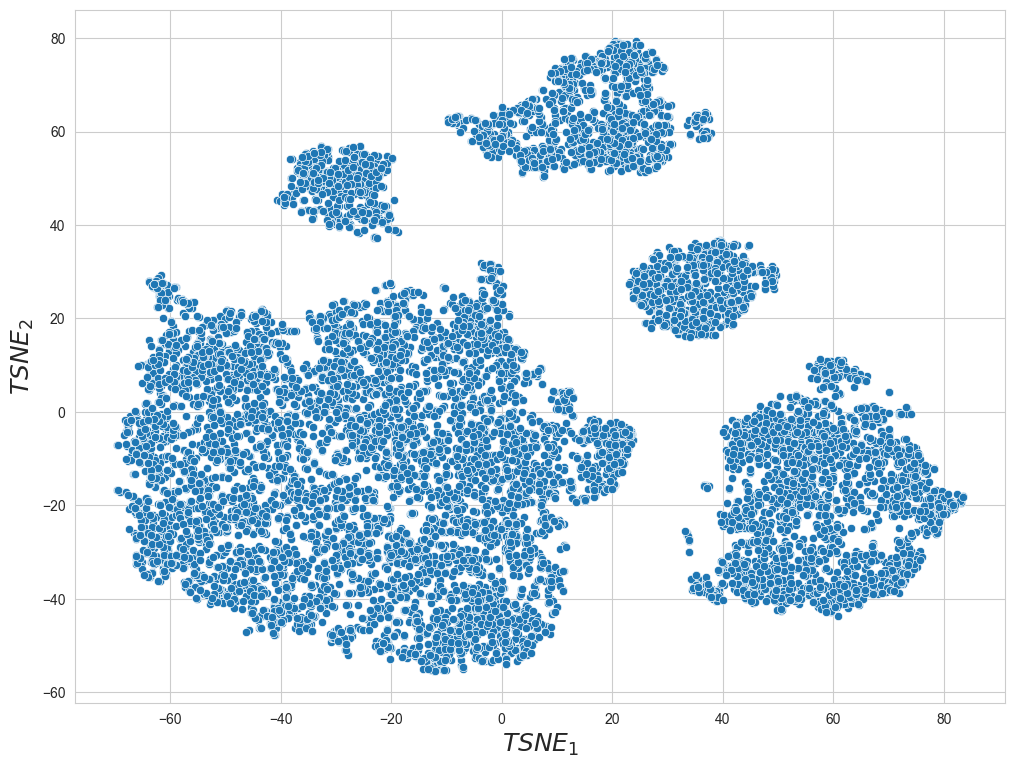

In [31]:
# По первым прикидкам у нас 5 кластеров

tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

#### Выполняю кластеризацию с помощью kMeans

In [32]:
# Реализую функцию для подбора kMEANS

def algorithm_selection_kmeans(X, algorithms, n_clusters):
    algorithms_list = []
    silhouette_scores = []
    for algorithm in algorithms:
        algorithms_list.append(algorithm)
        kmean_clust = KMeans(n_clusters=n_clusters, algorithm=algorithm)
        predictions = kmean_clust.fit_predict(X)
        silhouette = silhouette_score(X, predictions)
        silhouette_scores.append(silhouette)
    algorithms_list = pd.DataFrame(algorithms_list, columns=['algorithm'])
    silhouette_scores = pd.DataFrame(silhouette_scores, columns=['silhouette'])
    compare_dataframe = pd.concat((algorithms_list,
                                   silhouette_scores), axis=1)
    
    return compare_dataframe

In [33]:
# Вывожу таблицу полученных результатов

algorithms = ['lloyd', 'elkan']
n_clusters = 5 

kmeans_result = algorithm_selection_kmeans(fc_data, algorithms, n_clusters)
display.display(kmeans_result)

algorithm  silhouette
0     lloyd    0.350198
1     elkan    0.579442

Оба алгоритма сопоставимы по результатам. Elkan имеет чуть лучше показатель, поэтому используем его

In [34]:
# Обучаю модель и предсказываю их принадлежность к кластерам 

kmean_clust = KMeans(n_clusters=5, algorithm='elkan')
predictions = kmean_clust.fit_predict(fc_data)

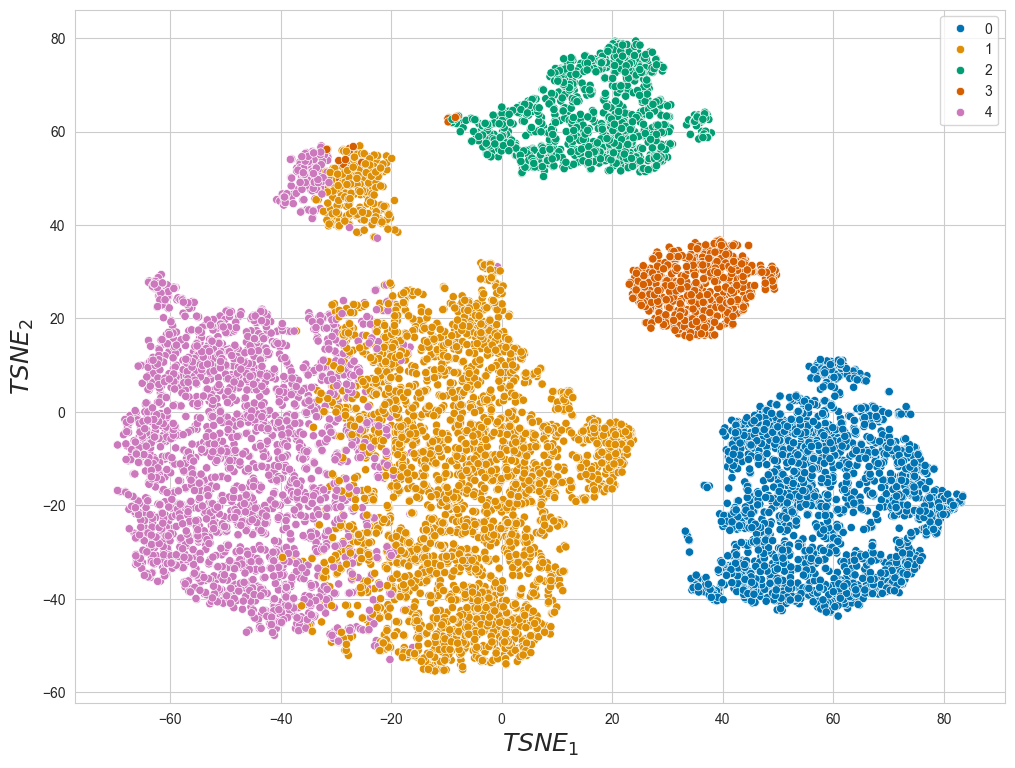

In [35]:
# Визуализирую полученный результат

tsne_res_1 = plot_tsne(fc_data, color=predictions)

**Вывод**

Ну не восторг

#### Использую иерархическую кластеризацию

In [36]:
# Получаю сравнительную таблицу 

distances = ['manhattan', 'euclidean', 'chebyshev', 'canberra', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = ['silhouette']
n_clusters = 5

agg_comparison_table = algorithm_selection(X=fc_data, 
                                           y=None, 
                                           distances=distances, 
                                           algorithms=algorithms, 
                                           metrics=metrics, 
                                           n_clusters=n_clusters)

display.display(agg_comparison_table)

distance   linkage homogenity completeness v_measure  silhouette
0   manhattan   average        NaN          NaN       NaN    0.590902
1   euclidean   average        NaN          NaN       NaN    0.607947
2   chebyshev   average        NaN          NaN       NaN    0.584242
3    canberra   average        NaN          NaN       NaN    0.164524
4      cosine   average        NaN          NaN       NaN    0.813940
5   manhattan    single        NaN          NaN       NaN    0.091411
6   euclidean    single        NaN          NaN       NaN    0.069061
7   chebyshev    single        NaN          NaN       NaN    0.130830
8    canberra    single        NaN          NaN       NaN    0.136720
9      cosine    single        NaN          NaN       NaN    0.032915
10  manhattan  complete        NaN          NaN       NaN    0.584626
11  euclidean  complete        NaN          NaN       NaN    0.587148
12  chebyshev  complete        NaN          NaN       NaN    0.369361
13   canberra  complete        NaN          NaN       NaN    0.138245
14     cosine  complete        NaN          NaN       NaN    0.693226

In [37]:
# Определяем максимальный показатель 

max_ind = agg_comparison_table['silhouette'].max()
agg_comparison_table[agg_comparison_table['silhouette'] == max_ind]

distance  linkage homogenity completeness v_measure  silhouette
4   cosine  average        NaN          NaN       NaN     0.81394

In [38]:
# Использую данные методы для подсчета расстояния и объединения данных

agg_clust = AgglomerativeClustering(n_clusters=5, metric='cosine', linkage='average')
predictions = agg_clust.fit_predict(fc_data)

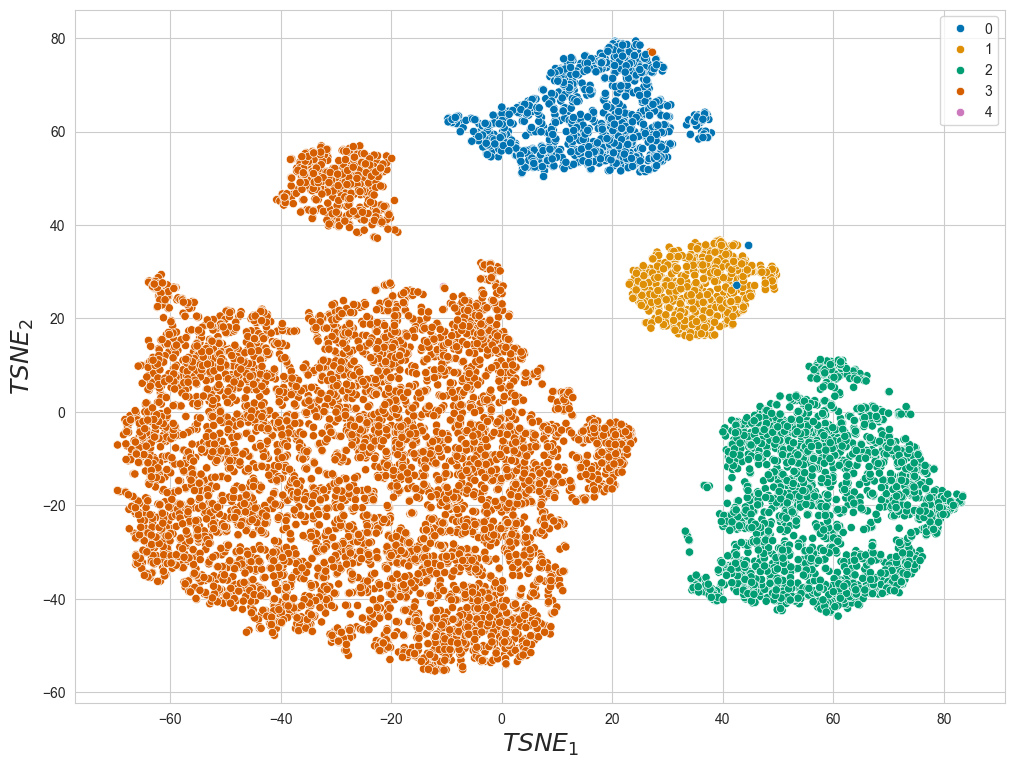

In [39]:
# Визуализирую полученный результат

tsne_res_2 = plot_tsne(fc_data, color=predictions)

**Вывод**

Результат намного лучше. Но, всё равно единичные клетки определяются в других кластерах. Что интересно, уже на данном этапе определяется 4 кластера, соотвествующих дальше 4 типам клеток. 

Пробую построить модель с исходными 4 кластерами

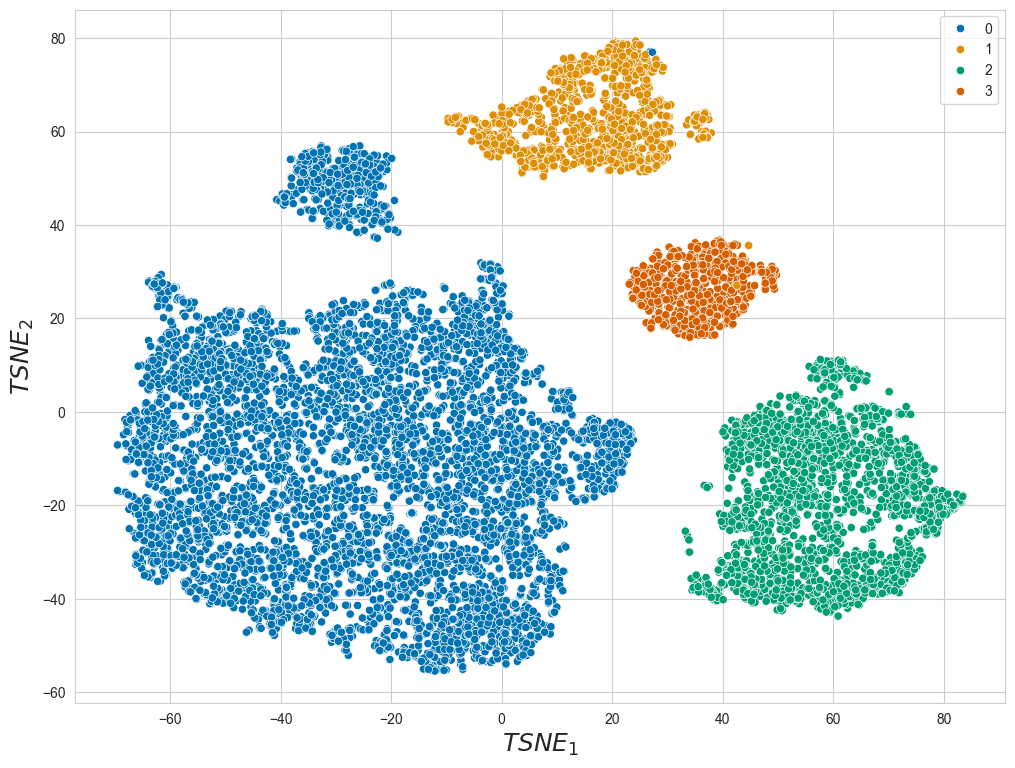

In [40]:
# Повторяю анализ с 4 кластерами

agg_clust_1 = AgglomerativeClustering(n_clusters=4, metric='cosine', linkage='average')
predictions = agg_clust_1.fit_predict(fc_data)

tsne_res_3 = plot_tsne(fc_data, color=predictions)

**Вывод**

Стало еще лучше. Но одно наблюдение всё еще не хочет уходить в свою кучку

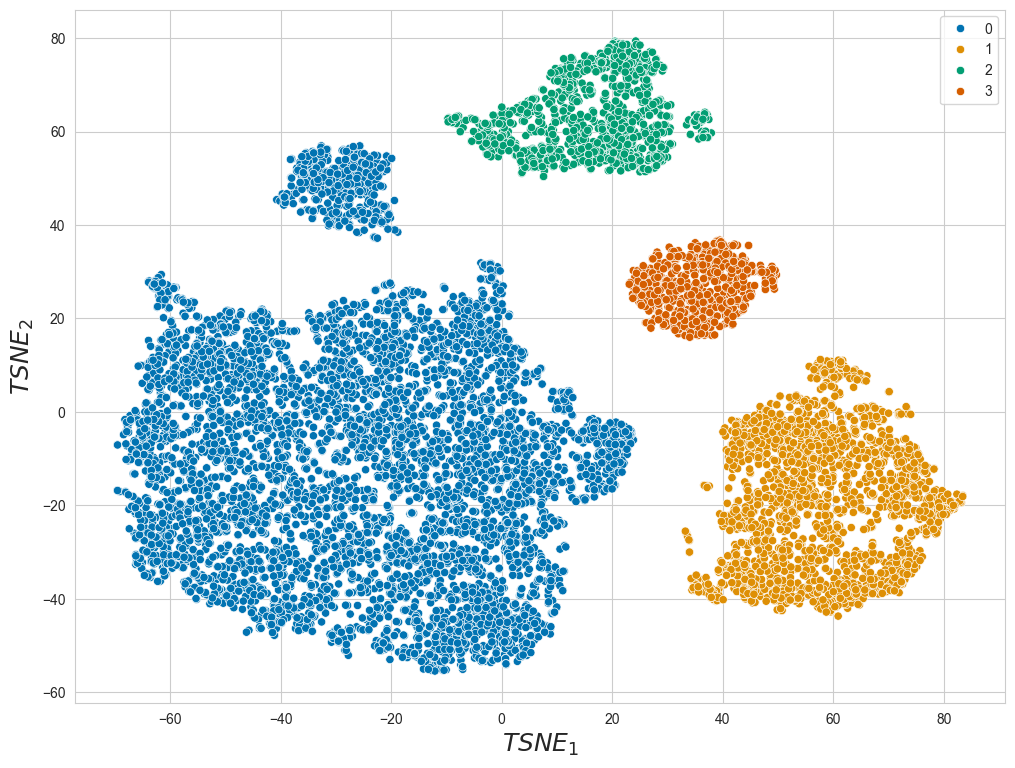

In [41]:
# Пробую выполнить иерархическую кластеризацию с дефолтными настройками
# Так как метод объединения в кластеры 'ward' считается самым оптимальным

agg_clust_2 = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
predictions = agg_clust_2.fit_predict(fc_data)

tsne_res_4 = plot_tsne(fc_data, color=predictions)

**Вывод**

Получилось разделить!

#### Сравниваю полученные результаты с алгоритмом DBscan

In [42]:
# Реализую функцию для подбора параметров DBscan
# DBscan имеет режим авто для подбора алгоритма, поэтому этот параметр не варьирую

def algorithm_selection_dbscan(X, eps_input, min_samples):
    min_samples_list = []
    silhouette_scores = []
    eps_list = []
    for number_sample in min_samples:
        for eps in eps_input:
            min_samples_list.append(number_sample)
            eps_list.append(eps)
            db_clust = DBSCAN(eps=eps, min_samples=number_sample)
            predictions = db_clust.fit_predict(X)
            silhouette = silhouette_score(X, predictions)
            silhouette_scores.append(silhouette)
    min_samples_list = pd.DataFrame(min_samples_list, columns=['min_samples'])
    eps_list = pd.DataFrame(eps_list, columns=['eps'])
    silhouette_scores = pd.DataFrame(silhouette_scores, columns=['silhouette'])
    compare_dataframe = pd.concat((min_samples_list,
                                   eps_list,
                                   silhouette_scores), axis=1)
    
    return compare_dataframe


In [43]:
eps=[0.5, 1, 1.5, 2]
min_samples = [5, 10, 15]

db_comp_table = algorithm_selection_dbscan(fc_data, eps_input=eps, min_samples=min_samples)

In [44]:
display.display(db_comp_table)

min_samples  eps  silhouette
0             5  0.5   -0.472569
1             5  1.0    0.202807
2             5  1.5    0.525658
3             5  2.0    0.574684
4            10  0.5   -0.391862
5            10  1.0    0.477838
6            10  1.5    0.595351
7            10  2.0    0.565001
8            15  0.5   -0.324688
9            15  1.0    0.487598
10           15  1.5    0.592083
11           15  2.0    0.599053

In [45]:
# Аналогично выбираю максимальный показатель, но вижу, что они ниже, чем в предыдущем анализе

max_ind = db_comp_table['silhouette'].max()
db_comp_table[db_comp_table['silhouette'] == max_ind]

min_samples  eps  silhouette
11           15  2.0    0.599053

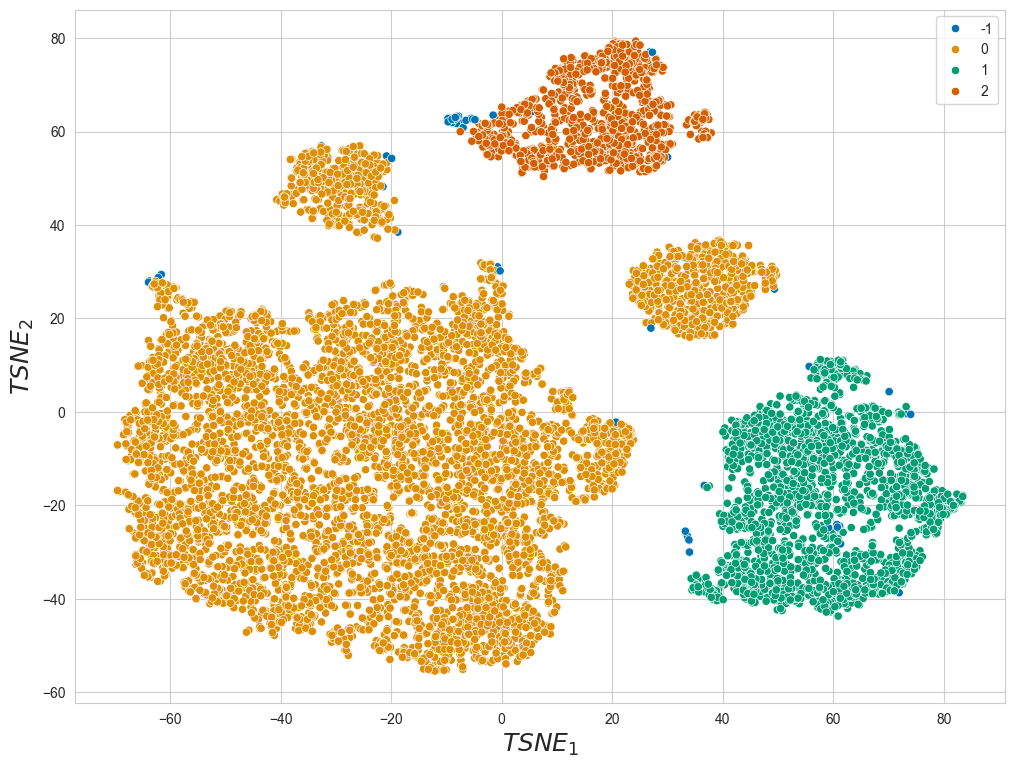

In [46]:
# Обучаю модель и визуализирую

db_clust = DBSCAN(eps=2, min_samples=15)
predictions = db_clust.fit_predict(fc_data)

tsne_res_5 = plot_tsne(fc_data, color=predictions)

**Вывод**

DBscan не подходит для данного анализа

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

**Ответ**

Разделение на отдельные 5 групп получить не удалось. Однако, получилось выполнить разделения всех полученных результатов на 4 кластера с помощью иерархической кластеризации с использование евклидова расстояния и метода объединения ward

In [47]:
# Использую данный метод для выполнения следующего задания

tna_res = tsne_res_4

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

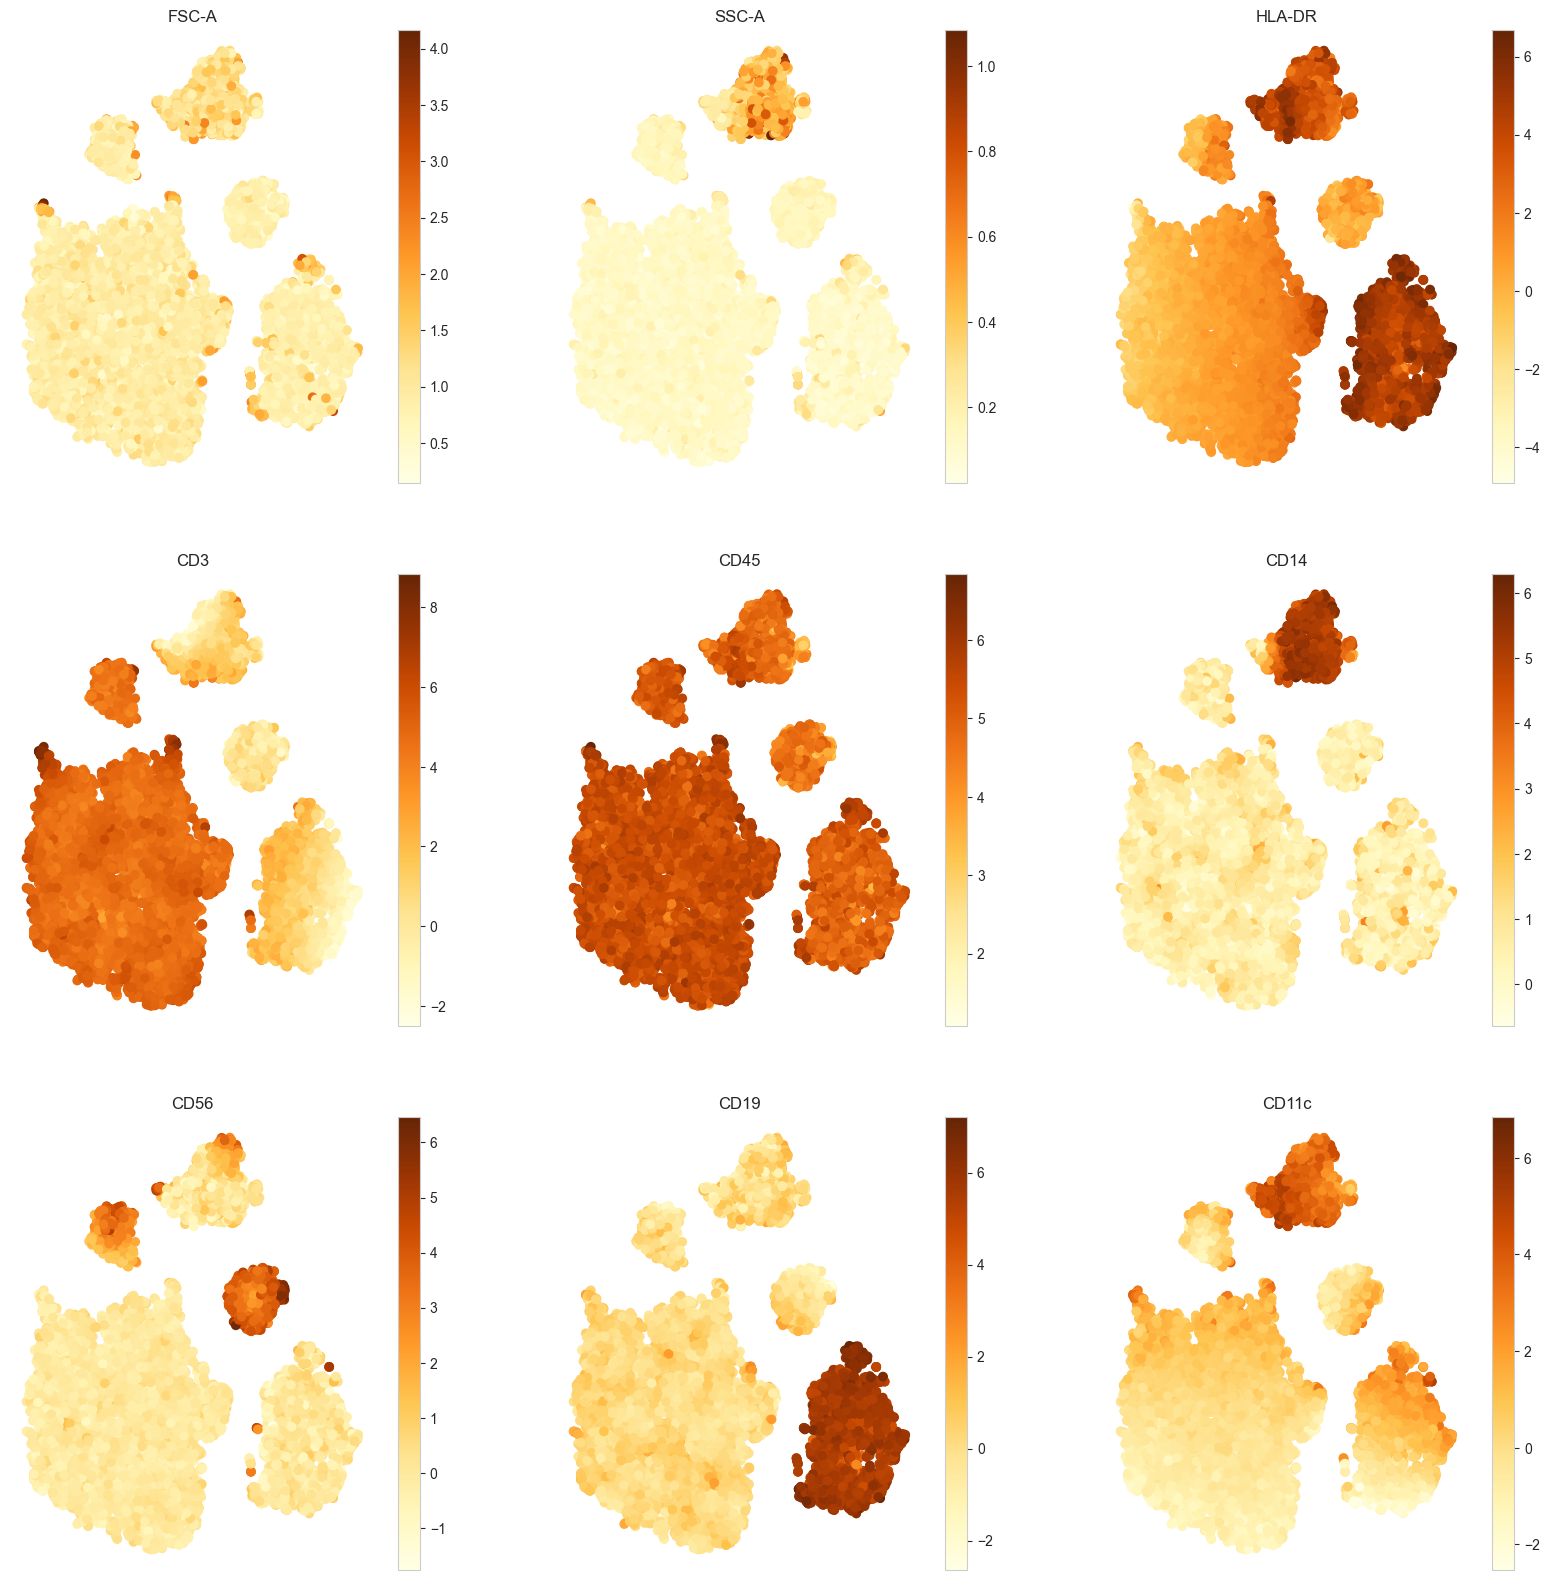

In [48]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [49]:
cell_type_cluster_map = {0: "T-cells", 
                         1: "B-cells", 
                         2: "Monocytes", 
                         3: "Other cells"}

In [50]:
labeled_fc_data = fc_data.assign(Population=agg_clust_2.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

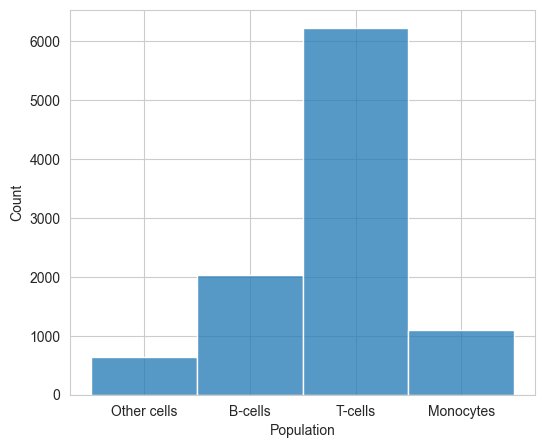

In [51]:
figure = plt.figure(figsize=(6, 5))
sns.histplot(labeled_fc_data['Population']);

In [52]:
labeled_fc_data.groupby(by=['Population']).count()['CD11c']

Population
B-cells        2035
Monocytes      1099
Other cells     635
T-cells        6220
Name: CD11c, dtype: int64

**Вывод**
- В распределнии есть явный сдвиг в сторону T-клеток

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [53]:
# Сохраняю результаты 
labeled_fc_data.to_csv('../data/processed_data/labeled_fc_data.csv', index=None)

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Самое любимое место - Алтай. Там самые красивые горы, озера и невероятная тишина. И еще можно в юртах пожить :) 

Абсолютный рекомендасьон 

<img src="../data/raw_data/altai.jpg">

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Это дз больше всего понравилось из трех, так как она больше всего была приближена к биологической реальности